In [0]:

from google.colab import drive
drive.mount('/content/drive')

from google.colab import files
import pandas as pd



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:

EPOCHS = 10
BATCH_SIZE = 30
HIDEN_STATE = 256
FILTER_SIZE = 150
KERNEL_SIZE = 3
embedding_dim=300
glove_path = 'drive/My Drive/glove.42B.300d.txt'
data_path = 'drive/My Drive/labeled_data.csv'

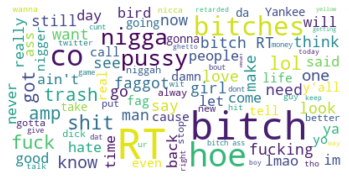

In [0]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
def _get_data():
        try:
            data = pd.read_csv(data_path, sep=',', header=None, error_bad_lines=False) # use pandas to read CSV
            data = data.dropna() # drop any rows with nans
            Y = data[5]     #label of tweet
           
            return data[6].values, Y.values

        except ValueError:
            return None, None

text = _get_data()[0][0]
for t in _get_data()[0][1:]:
  text += " "+ str(t)

# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [0]:
import io
import os
import re
import string
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint
from sklearn.externals import joblib
from sklearn import preprocessing
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
import pdb
from wordcloud import WordCloud

import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import pipeline, feature_extraction, svm, metrics
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import random
  
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import pipeline, feature_extraction, svm, metrics
from keras.layers import Bidirectional
try:
  from keras_self_attention import SeqSelfAttention
except:
  !pip install keras-self-attention
  from keras_self_attention import SeqSelfAttention



def _get_model( vocabulary_size=1, input_length=1, load_weights=False):
    try:
        model = Sequential()
        model.add(Embedding(vocabulary_size, 16, input_length=input_length))
        model.add(MaxPooling1D(5))
        model.add(LSTM(10))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
        return model
    except ValueError:
        return None




Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Data preprocessing functions

In [0]:
lemmatizer = WordNetLemmatizer()

TAG_RE = re.compile(r'<[^>]+>')

def _get_vocabulary(documents):
    return set(" ".join(documents).split())

def _get_tokenizer(documents):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(documents)
    return tokenizer

def _clean_documents(documents):
    # convert to list
    documents = documents.tolist()
    # clean docs
    print("Starting cleaning %s documents" % len(documents))
    documents = [_clean_doc(doc) for doc in documents]
    return documents

def _clean_doc( doc):
    # remove HTML tags
    doc = _clean_tags(doc)
    # replace all newlines and tabs
    doc = doc.replace('\\n', ' ').replace('\\r', ' ').replace('\\t', ' ')
    # add missing space after full stops and commas
    doc = re.sub(r'(?<=[.,])(?=[^\s])', r' ', doc)
    
    # create tokens
    tokens = word_tokenize(doc)
    # downcase
    tokens = [w.lower() for w in tokens]
    # regexp
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    stripped = [re_punc.sub('', w) for w in tokens]
    # remove non-alphabetic tokens
    words = [word for word in stripped if word.isalpha()]
    print('.', end='', flush=True)
    return " ".join(words)

def _clean_tags( text):
    return TAG_RE.sub('', text)

Data preprocessing

In [0]:
#data preprocessing
try:
  X, Y = _get_data()
  documents = _clean_documents(X)
except:
  nltk.download("stopwords")
  nltk.download('punkt')
  X, Y = _get_data()
  documents = _clean_documents(X)

Starting cleaning 24783 documents
......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

vocabulary = _get_vocabulary(documents)
vocab_size = len(vocabulary) + 1

tokenizer = Tokenizer()
tokenizer.fit_on_texts(documents)

word_index = tokenizer.word_index   #a dictionary with word as key and index as value

word_value = dict([(v,k) for k, v in word_index.items()]) # a dictionary with index as key and word as value

tokenizer = _get_tokenizer(documents)
max_document_length = max([len(s.split()) for s in documents])
encoded = tokenizer.texts_to_sequences(documents)
X = sequence.pad_sequences(encoded, maxlen=max_document_length)

Read GLOVE

In [0]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100

#read glove embedding from my google drive
embeddings_index = {}
f = open(glove_path)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))



Found 1917494 word vectors.


This method is used to Initialize glove embedding matrix

In [0]:
def init_embedding_matrix():
  embedding_matrix = np.zeros((len(word_index) + 1, 300))
  for word, i in word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          # words not found in embedding index will be all-zeros.
          embedding_matrix[i] = embedding_vector
      else: embedding_matrix[i] = random.random()
  return embedding_matrix


This function is used to initialize LSTM model

In [0]:
from keras.models import Model
from keras.layers import *
import numpy as np
from keras import backend as K
def LSTM_model():
        #initialize embedding matrix
        embedding_matrix = init_embedding_matrix()
        #create and add layers to LSTM modle
        model = Sequential()
        #add embedding layer for my modle i use pretrained glove300d 
        model.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_document_length, trainable=True))
        #randomly drop some features to avoid overfitting
        model.add(Dropout(0.5))   
        #add lstm layer
        model.add(LSTM(HIDEN_STATE, return_sequences = True))
        #add attention layer
        model.add(SeqSelfAttention(attention_activation='sigmoid'))
        #flatten
        model.add(GlobalAveragePooling1D())
        #end make out put of 3 categories
        model.add(Dense(3, activation="softmax"))
        #compile with adam
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model


In [0]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import pipeline, feature_extraction, svm, metrics
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
try:
  from keras_self_attention import SeqSelfAttention
except:
  !pip install keras-self-attention
  from keras_self_attention import SeqSelfAttention
def CNN_model():

        #initialize embedding matrix
        embedding_matrix = init_embedding_matrix()
        #create and add layers to LSTM modle
        model = Sequential()
        #add embedding layer for my modle i use pretrained glove300d 
        model.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_document_length, trainable=True))
        #randomly drop some features to avoid overfitting
        model.add(Dropout(0.5))   
        #add lstm layer
        model.add(Conv1D(filters=FILTER_SIZE, kernel_size=KERNEL_SIZE, padding='same', activation='relu'))
        #add attention layer
        model.add(SeqSelfAttention(attention_activation='sigmoid'))
        #flatten
        model.add(GlobalAveragePooling1D())
        #end make out put of 3 categories
        model.add(Dense(3, activation="softmax"))
        #compile with adam
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model


In [0]:
def classify(model, X, y):
    # self.split(X,y)
    cv = StratifiedKFold(n_splits=5)
    results = [0,0,0, 0,0,0,0,0,0]
    for train_idx, test_idx, in cv.split(X, y):
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]
        model.fit(X_train, y_train, validation_split=0.25, epochs=10, batch_size=BATCH_SIZE, verbose=1)

        names = [weight.name for layer in model.layers for weight in layer.weights]
        weights = model.get_weights()

        y_pred = model.predict_classes(X_test)

        y_test = [int(i) for i in y_test]

        results = [x + y for x, y in zip(results , list( metrics.precision_recall_fscore_support(y_test, y_pred, average="macro")[:-1] + metrics.precision_recall_fscore_support(y_test, y_pred, average="weighted")[:-1]))]
        
    print([round(x/5 , 2) for x in results ])

In [14]:
%tensorflow_version 1.x
import tensorflow
LSTM_model = LSTM_model()
print("starting lstm")
result = classify(LSTM_model, X, Y)

TensorFlow is already loaded. Please restart the runtime to change versions.
starting lstm


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 14869 samples, validate on 4957 samples
Epoch 1/10
  630/14869 [>.............................] - ETA: 3:03 - loss: 0.7958 - accuracy: 0.7302

KeyboardInterrupt: ignored

In [16]:
CNN_model = CNN_model()
print("starting CNN")
classify(CNN_model, X, Y)

starting CNN


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 14869 samples, validate on 4957 samples
Epoch 1/10
  930/14869 [>.............................] - ETA: 1:27 - loss: 0.6539 - accuracy: 0.7785

KeyboardInterrupt: ignored

In [0]:
#check layers and weight of CNN model you can also modify it to check weights for lasm model
for layer in CNN_model.layers:
  g=layer.name
  h=layer.get_weights()
  print (g)
  try:
   print (h)
  except:
    pass